In [2]:
from sirf.Gadgetron import AcquisitionData, CoilSensitivityData, AcquisitionModel, ImageData
from sirf.Utilities import assert_validity

import numpy as np
import sys
sys.path.append("/home/jovyan/P1-Temp-Reg/modelbased-approach/")
import auxiliary_functions as aux

In [3]:
def get_test_img():

    filepath_y = "/home/jovyan/InputData/y_4.h5"
    y = AcquisitionData(filepath_y)
    u = ImageData()
    u.from_acquisition_data(y)


    csm = CoilSensitivityData()
    csm.calculate(y)

    A = AcquisitionModel(acqs=y, imgs=u)
    A.set_coil_sensitivity_maps(csm)

    u_test = A.inverse(y)

    return u_test

In [4]:
class Gradient1D_Local:
    
    def __init__(self, axis, weights):
        assert_validity(weights, ImageData)
        self.weights=weights
        self.axis = axis

    def forward(self, u):
        assert_validity(u, ImageData)
        return self.weights*u.copy().fill(np.roll(u.as_array(), -1, axis=self.axis) - u.as_array())
    
    def backward(self, u ):
        assert_validity(u, ImageData)
        res = np.roll((self.weights * u).as_array(), 1, axis=self.axis) - (self.weights*u).as_array()
        u = u.copy().fill(res)
        
        return u   


Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5


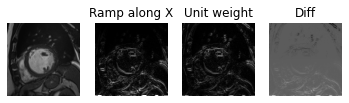

True

In [5]:
import matplotlib.pyplot as plt
import numpy as np
def test_local_Gradient1D():

    u = get_test_img()
    
    alpha = u.copy()
    beta = u.copy()
    unit_weights = u.copy()
    
    arr_shape = alpha.as_array().shape
    
    X,T,Y = np.meshgrid( np.arange(-arr_shape[1]//2, arr_shape[1]//2), \
                         np.arange(-arr_shape[0]//2, arr_shape[0]//2), \
                         np.arange(-arr_shape[2]//2, arr_shape[2]//2))
    
    unit_weights.fill(1.0)
    alpha.fill( 1 + X/np.max(X))
    
    Gx = Gradient1D_Local(weights = alpha, axis = 1)
    Gx_unit = Gradient1D_Local(weights = unit_weights, axis = 1)
    
    
    dxu = Gx.forward(u)
    unit_dxu = Gx_unit.forward(u)
    
    
    f,ax = plt.subplots(1,4)
    ax[0].imshow( np.abs(u.as_array()[0,:,:]),cmap='gray', vmin=0, vmax=50 ) 
    ax[0].axis("off")
    
    brightness_increase = 1
    ax[1].imshow( np.abs(dxu.as_array()[0,:,:]),cmap='gray', vmin=0, vmax=20 )  
    ax[1].axis("off")
    ax[1].set_title("Ramp along X")
    
    ax[2].imshow( np.abs(unit_dxu.as_array()[0,:,:]),cmap='gray', vmin=0, vmax=20 ) 
    ax[2].set_title("Unit weight")
    ax[2].axis("off")
    ax[3].imshow( np.abs(dxu.as_array()[0,:,:]) - np.abs(unit_dxu.as_array()[0,:,:]),cmap='gray' )
    ax[3].set_title("Diff")
    ax[3].axis("off")

    plt.show()
    
    return True

test_local_Gradient1D()

In [6]:
u = aux.get_test_img()

weights = u.fill(np.random.randn(*u.as_array().shape))

Gt = Gradient1D_Local(weights = weights, axis = 0)
Gx = Gradient1D_Local(weights = weights, axis = 1)
Gy = Gradient1D_Local(weights = weights, axis = 2)


Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5


In [7]:
assert aux.test_image_operator_adjointness(Gt), "Gt is not adjoint"
assert aux.test_image_operator_adjointness(Gx), "Gx is not adjoint"
assert aux.test_image_operator_adjointness(Gy), "Gy is not adjoint"

Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
1.3181174872010792e-06
Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
4.6596948852048715e-06
Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
3.0108132929299392e-06


In [8]:
Dtlocal = aux.Dt_Local(weights)
assert aux.test_image_operator_adjointness(Dtlocal), "Dt local is not adjoint"

Dxlocal = aux.Dx_Local(weights=weights)
assert aux.test_stacked_image_operator_adjointness(Dxlocal), "Dx Local is not adjoint"


Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
2.5489403836344627e-06
Started reading acquisitions from /home/jovyan/InputData/y_4.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from /home/jovyan/InputData/y_4.h5
7.29339349498919e-06
